In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
PATH = "/content/synthetic_moderate_potholes.csv"
# PATH = "/content/bad5_sensors.csv"
df = pd.read_csv(PATH)
print("Data Loaded. Columns:", df.columns.tolist())
df.head()

Data Loaded. Columns: ['timestamp', 'latitude', 'longitude', 'speed', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroX', 'gyroY', 'gyroZ']


,timestamp,latitude,longitude,speed,accelerometerX,accelerometerY,accelerometerZ,gyroX,gyroY,gyroZ
0,1.493479e+09,40.478650,-79.922701,30.0,0.037849,-0.881566,0.406261,0.035567,0.048024,0.008764
1,1.493479e+09,40.478652,-79.922699,30.0,-0.046108,-0.919667,0.378530,0.008976,0.008787,-0.004021
2,1.493479e+09,40.478654,-79.922695,30.0,0.043480,-0.898563,0.406115,0.003636,-0.004168,-0.003697
3,1.493479e+09,40.478657,-79.922693,30.0,0.067782,-0.836077,0.427165,0.019933,-0.020274,0.016254
4,1.493479e+09,40.478656,-79.922692,30.0,0.020672,-0.890445,0.402443,0.016596,-0.026063,-0.006894


Estimated sample rate: 5.0 Hz (median dt 0.200 s)
Segment roughness (90th percentile z-score): 1.053
Recommended speed (based on R_z mean): 61.89 km/h (multiplier 0.884)


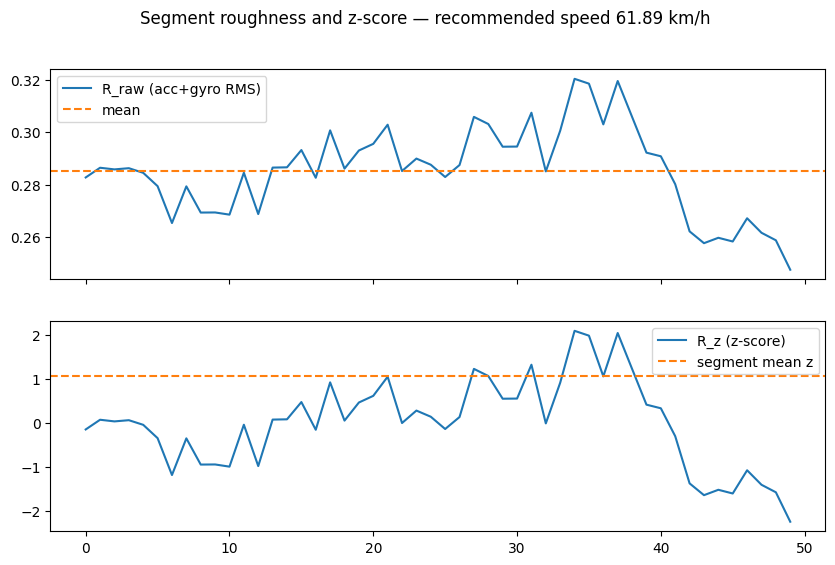

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.signal import detrend
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# 2) load (adjust path if needed)

# 3) optional: restrict to the traffic-light segment using lat/lon box
# Replace these with the bounding box around your traffic light (degrees)
LAT_MIN, LAT_MAX = 40.4786, 40.4788
LON_MIN, LON_MAX = -79.9228, -79.9226

seg = df[(df['latitude'] >= LAT_MIN) & (df['latitude'] <= LAT_MAX) &
         (df['longitude'] >= LON_MIN) & (df['longitude'] <= LON_MAX)].copy()

if seg.empty:
    seg = df.copy()   # fallback to whole trip if box empty

# 4) ensure chronological order
seg = seg.sort_values('timestamp').reset_index(drop=True)

# 5) compute vertical accel dev (if accelerometer in m/s^2; if in g, adjust)
# If accel values are small (~0.3..1.0) they may already be in g; we'll work with raw magnitudes.
# Use accelerometerZ (vertical axis) and gyroZ (yaw rate) as examples.
seg['acc_z'] = seg['accelerometerZ'].values
seg['gyro_z'] = np.abs(seg['gyroZ'].values)  # magnitude

# 6) sliding-window RMS roughness (window seconds -> convert to samples via sampling rate)
# Estimate sampling rate from timestamp differences (timestamps in Unix seconds)
dts = np.diff(seg['timestamp'].values)
median_dt = np.median(dts) if len(dts)>0 else 0.05
sr = 1.0 / median_dt if median_dt>0 else 50.0
print(f"Estimated sample rate: {sr:.1f} Hz (median dt {median_dt:.3f} s)")

# choose window length (1.0–2.0 s recommended)
WIN_SECONDS = 1.0
win_samples = max(3, int(round(WIN_SECONDS * sr)))

# RMS function via uniform_filter for speed
def sliding_rms(x, win):
    x2 = x**2
    # moving average of squared signal then sqrt
    mean_sq = uniform_filter1d(x2, size=win, mode='nearest')
    return np.sqrt(mean_sq)

seg['acc_z_rms'] = sliding_rms(seg['acc_z'].values, win_samples)
seg['gyro_z_rms'] = sliding_rms(seg['gyro_z'].values, win_samples)

# 7) combine into single roughness index R (weighted)
# weights chosen so vertical accel has more influence
WA, WG = 0.7, 0.3
seg['R_raw'] = WA * seg['acc_z_rms'] + WG * seg['gyro_z_rms']

# 8) normalize R (z-score) using segment or global stats
mu_R = seg['R_raw'].mean()
sigma_R = seg['R_raw'].std(ddof=0) if seg['R_raw'].std(ddof=0) > 1e-6 else 1.0
seg['R_z'] = (seg['R_raw'] - mu_R) / sigma_R

# 9) use 90th percentile z-score for roughness (more sensitive to peaks)
segment_z = np.percentile(seg['R_z'], 85)
print(f"Segment roughness (90th percentile z-score): {segment_z:.3f}")

# 10) compute recommended speed
MIN_FRAC = 0.3
REDUCTION_PER_SD = 0.11
BASE_SPEED = 70  # km/h
speed_mult = max(MIN_FRAC, 1.0 - REDUCTION_PER_SD * segment_z)
recommended_speed = round(BASE_SPEED * speed_mult, 2)

print(f"Recommended speed (based on R_z mean): {recommended_speed} km/h (multiplier {speed_mult:.3f})")

# 11) (Optional) Plot R_raw and R_z with histogram
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
axes[0].plot(seg['R_raw'].values, label='R_raw (acc+gyro RMS)')
axes[0].axhline(mu_R, color='C1', linestyle='--', label='mean')
axes[0].legend()
axes[1].plot(seg['R_z'].values, label='R_z (z-score)')
axes[1].axhline(segment_z, color='C1', linestyle='--', label='segment mean z')
axes[1].legend()
plt.suptitle(f"Segment roughness and z-score — recommended speed {recommended_speed} km/h")
plt.show()


**Z-score normalization (standardization):**

  $R_z = \frac{R - \mu_R}{\sigma_R}$

   Here, values are centered around the mean (0) and measured in units of standard deviation.

   * $(R_z = 0)$: average roughness
   * $(R_z = +1)$: one SD rougher than average
   * $(R_z = -1)$: one SD smoother than average

$“normalized” (R_z)$ here is actually *standardized*, not min-max scaled. It keeps values around 0 (not 0–1) and is useful for detecting statistical deviations — perfect for identifying unusually rough or smooth patches.


The **orange mean line** appears straight because it represents a **constant statistical average** of the entire signal — the mean roughness level (like a baseline).

### Significance:

* Points above it indicate **higher vibration/roughness**, and points below indicate **smoother road sections**.
* The mean value is computed once for the dataset:
  $
  \bar{R} = \frac{1}{N} \sum_{i=1}^{N} R_i
  $
* Visually, it helps see **how far the data fluctuates** from normal road behavior.